In [1]:
import importlib
import numpy as np
import sklearn
from matplotlib import pyplot as plt
from os.path import join
import os
import seaborn as sns
from tqdm.notebook import tqdm as tqdm_notebook
import pickle
import glob
#### Custum libraries
import lib.algos_maxRSA as max_rsa
import lib.utils_RSA as rsa
import lib.utils_CKA as cka
from lib.algos import *


importlib.reload(rsa)
importlib.reload(cka)
importlib.reload(max_rsa)

<module 'lib.algos_maxRSA' from '/home/alban/projects/SAYCam_Vs_EGO4D/lib/algos_maxRSA.py'>

In [3]:
dataset = 'ecoLennyTest'
models  = ['ego', 'saycam', 'imagenet', 'supervised', 'random', 'resnet']
#models  = ['ego', 'saycam']
path2activations = f'/home/alban/Documents/activations_datadriven/%s_{dataset}/'

imagelists = {}
activations = {}
for model in models:
    with open(join(path2activations%model, 'imagepaths.txt'), 'r') as f:
        imagelists[model] = [line.strip() for line in f.readlines()]
    activations[model] = np.load(join(path2activations % model, 'cls_tokens.npy'))

activations[model].shape

(28250, 2048)

In [4]:
#### Normalize vectors
for model in models:
    norms = np.linalg.norm(activations[model], axis=1, keepdims=True)
    activations[model] = activations[model]/norms # normalization

### check if images were shown in the same order
assert imagelists['ego'] == imagelists['saycam']
imagelist = imagelists['ego']  # since they are the same, only consider one list

#### check if each category has the same number of images and list all categories in listcats
count = 0
cat = ''
listcat = list()
for i, imgp in enumerate(imagelist):
    current_cat = imgp.split('/')[-2]
    if i == 0:
        cat = current_cat
        listcat.append(current_cat)
    if cat != current_cat:
        cat = current_cat
        listcat.append(current_cat)
        count = 1
    else:
        count += 1

nb_per_cat = count  # in val, 50 images per cate

nb_per_cat

### reshape activations according to include categories
cat_activations = activations.copy()

for model in models:
    shape = activations[model].shape
    cat_activations[model] = activations[model].reshape(-1, nb_per_cat, shape[-1])

In [5]:
### Compute representational compactness for each category and model
compactness, compact_categories = max_rsa.compute_compactness(cat_activations, models, listcat, measure = 'Fisher_discriminant')



ego
saycam
imagenet
supervised
random
resnet


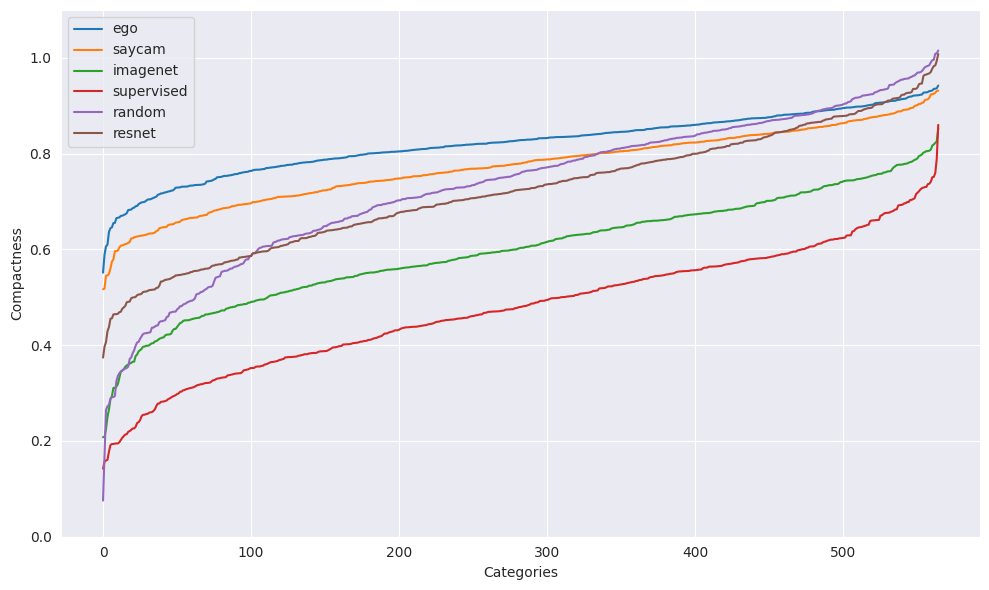

In [49]:
fig_compactness, ax_compactness = max_rsa.plot_stats_one(compactness,models,  ['Categories', 'Compactness'], savename='Fisher_descriminant_allmodels.png')

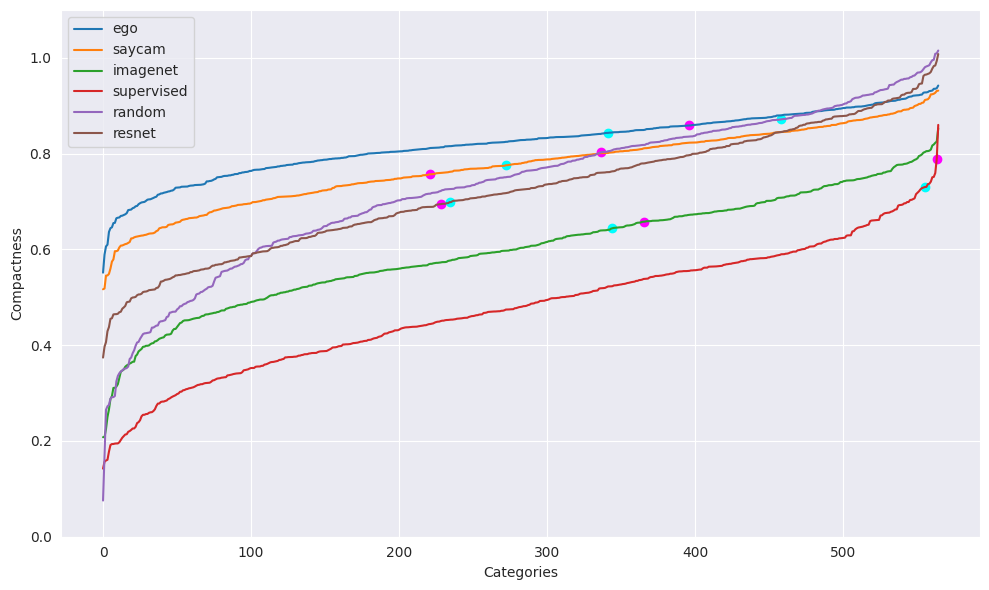

In [50]:
for model in models:
    index = np.array(range(len(compact_categories[model])))[compact_categories[model] == '0001_man']
    ax_compactness.scatter(index,compactness[model][index], color = 'magenta')
    index = np.array(range(len(compact_categories[model])))[compact_categories[model] == '0020_woman']
    ax_compactness.scatter(index,compactness[model][index], color = 'cyan')
fig_compactness

In [51]:
for model in models:
    print(f'{model}')
    print(compact_categories[model][:10])

ego
['1073_fireworks' '0156_moon' '0089_bus' '2144_newsstand' '0812_coin'
 '0005_house' '2400_geyser' '0082_kitchen' '0266_gravel' '0009_car']
saycam
['0089_bus' '1073_fireworks' '1612_forklift' '2144_newsstand'
 '0082_kitchen' '0005_house' '2400_geyser' '1043_mall' '0009_car'
 '2112_photocopier']
imagenet
['0847_jaguar' '2098_odometer' '2400_geyser' '1129_zebra' '1892_panda'
 '1335_dragonfly' '0209_leopard' '2186_cheetah' '0132_tiger'
 '0764_gondola']
supervised
['1829_blimp' '1892_panda' '2186_cheetah' '0909_flea' '0847_jaguar'
 '2098_odometer' '1264_mantis' '1129_zebra' '0764_gondola'
 '1515_waterspout']
random
['1073_fireworks' '0156_moon' '0047_fire' '1515_waterspout'
 '2112_photocopier' '2527_helicopter' '0488_iceberg' '2673_gearshift'
 '0353_whale' '2098_odometer']
resnet
['2144_newsstand' '0082_kitchen' '0089_bus' '1612_forklift' '1043_mall'
 '0005_house' '0857_waterfall' '0009_car' '0137_train' '1152_altar']


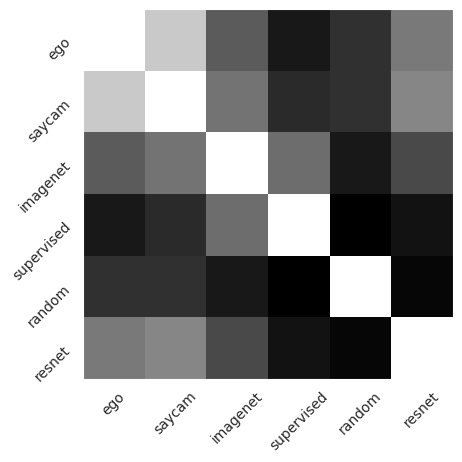

In [52]:
def check_list_similarity(list1, list2):
    '''Checks if two lists contain the same elements, regardless of order,
    and calculates the proportion of common elements.'''
    set1 = set(list1)
    set2 = set(list2)
    common_elements = set1 & set2  # Intersection of sets
    proportion = (len(common_elements) / max(len(set1), len(set2))) * 100 if max(len(set1), len(set2)) > 0 else 0
    return proportion

model_overlap_matrix = np.zeros((len(models), len(models)))
for m1, model1 in enumerate(models):
    for m2, model2 in enumerate(models):
        model_overlap_matrix[m1,m2] = check_list_similarity(compact_categories[model1][:50],compact_categories[model2][:50])
plt.rcParams['axes.grid'] = False
plt.imshow(model_overlap_matrix, cmap = 'grey')
plt.xticks(np.arange(len(models)), models, rotation = 45)
plt.yticks(np.arange(len(models)), models, rotation = 45)
plt.show()

In [53]:
nb_categories = len(listcat)
labels, sortedmaxdiffcats, maxdiffs = max_rsa.max_compactness_difference(compact_categories, compactness, nb_categories, listcat, models = ['saycam', 'resnet'], nb_considered_categories = 12, compactness_diff_measure = 'normalizedDiff')

12
The 12 categories leading to the max differences between saycam and resnet are ['0005_house' '0052_fish' '0071_camera' '0116_flower' '0117_ring'
 '0593_butterfly' '0065_tree' '1846_spareribs' '0982_tortilla'
 '0068_clock' '0513_acorn' '1048_potato']
Category numbers are [  1  13  20  36  37 198  17 468 289  18 185 310]
With differences in compactness of  [ 0.8947907   0.85127604  0.82506657  0.68673277  0.5943679  -0.5872824
  0.5853878  -0.5622632  -0.5538664   0.54549885  0.53942156  0.5320416 ]


In [54]:
listpickles_ecoVal = glob.glob('/home/alban/Documents/results_image_selection/ecoVal_*.pkl')

RESULTS = {}
for p, pkl in enumerate(listpickles_ecoVal):
    name = pkl.split('/')[-1][:-4]
    f = open(pkl,"rb")
    RESULTS[name] = pickle.load(f)
    f.close()

In [55]:
list_names = [k for k in RESULTS.keys()]
similarities = {}

for n, name in enumerate(list_names):
    similarities[name] = [RESULTS[name]['similarity_dict'][pair]['similarity'] for pair in RESULTS[name]['similarity_dict'].keys()]

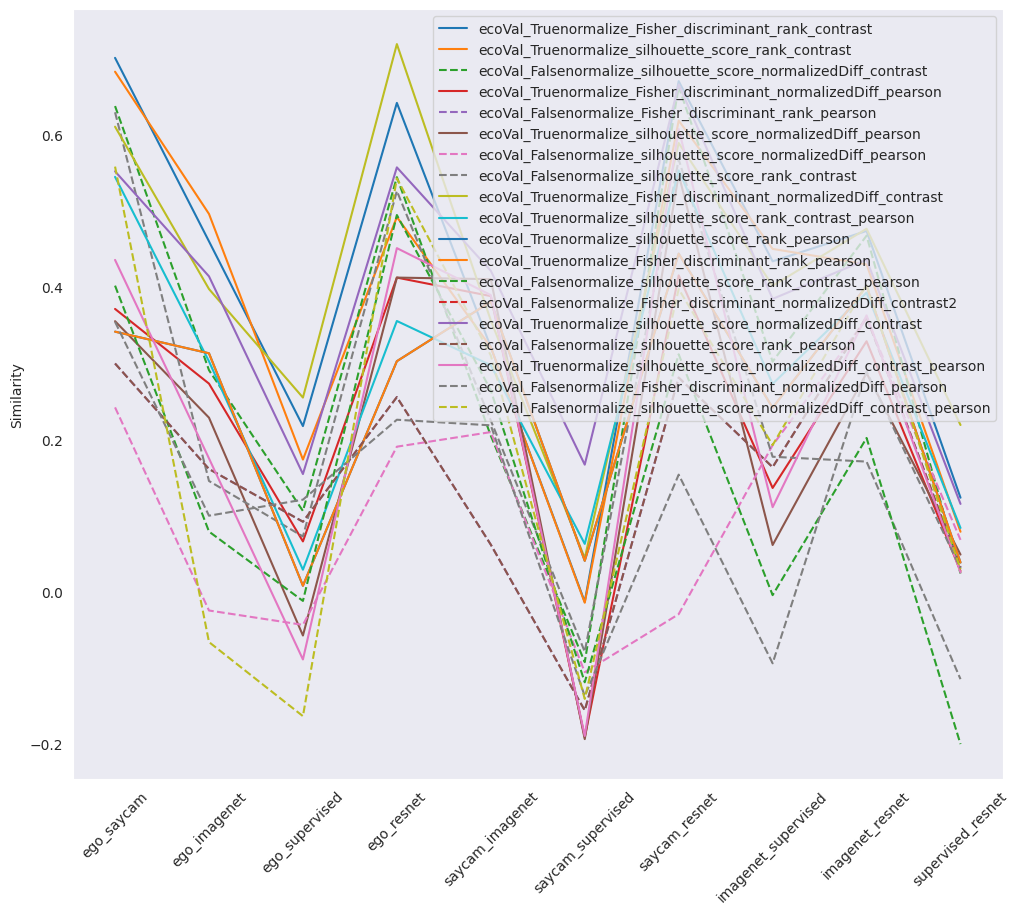

In [56]:
fig, ax = plt.subplots(figsize = (12,10))
for name in similarities.keys():
    if 'Falsenormalize' in name:
        plt.plot(similarities[name], label = name, ls = '--')
    else:
        plt.plot(similarities[name], label = name)
plt.ylabel('Similarity')
plt.xticks(list(range(10)), [pair for pair in RESULTS[name]['similarity_dict'].keys()], rotation = 45)
plt.legend(loc = 'upper right')
plt.show()

[np.float64(0.5443188737180884), np.float64(0.30216892373820203), np.float64(0.02868964433565088), np.float64(0.35515050771005024), np.float64(0.2970364882391842), np.float64(0.06262004564644308), np.float64(0.5527382884992312), np.float64(0.27263069920763616), np.float64(0.3923368713755579), np.float64(0.08352565834694824)]
[np.float64(0.43531380921849355), np.float64(0.1747588183718934), np.float64(-0.08907032471783967), np.float64(0.4507881922586924), np.float64(0.3891432155456687), np.float64(-0.1894800589344373), np.float64(0.6071199667906791), np.float64(0.11079099562177264), np.float64(0.3625056633565517), np.float64(0.025168212020033706)]


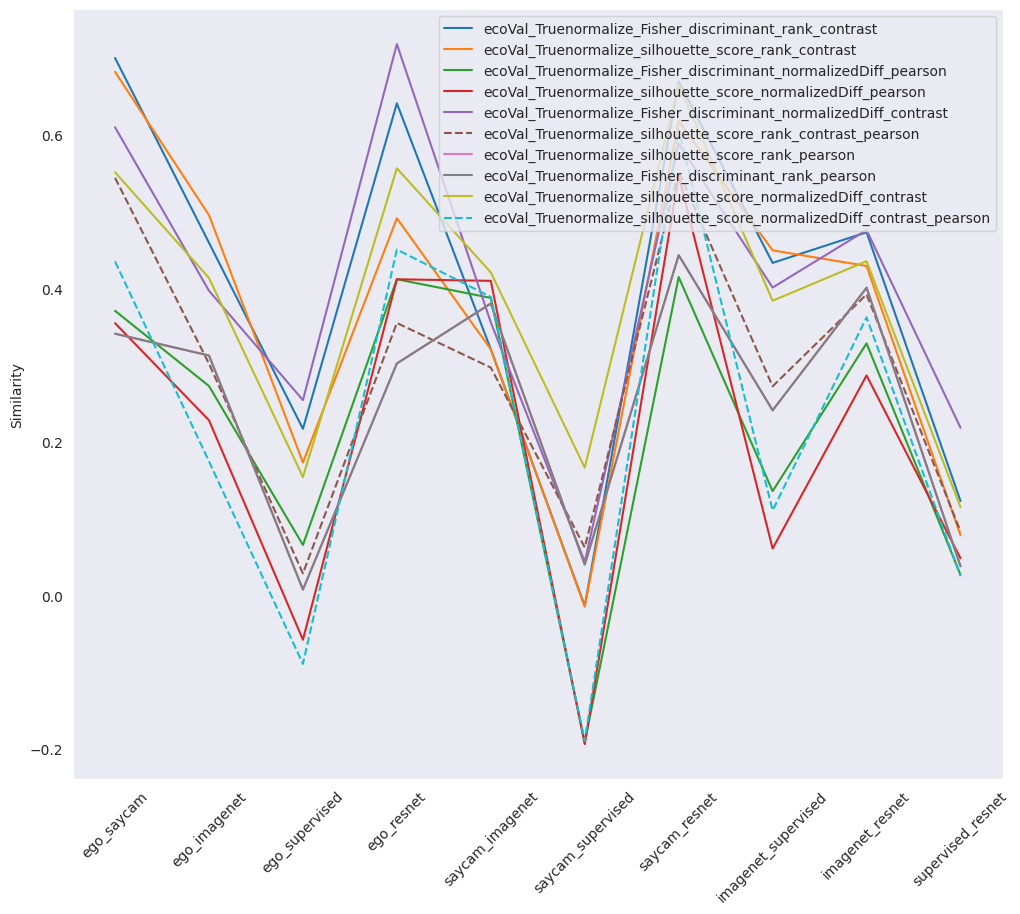

In [64]:
fig, ax = plt.subplots(figsize = (12,10))
for name in similarities.keys():
    if 'Falsenormalize' in name:
        continue
    elif 'contrast_pearson' in name:
        plt.plot(similarities[name], label = name, ls = '--')
        if 'ecoVal_Truenormalize_silhouette_score' in name:
            print(similarities[name])
    else:
        plt.plot(similarities[name], label = name)
plt.ylabel('Similarity')
plt.xticks(list(range(10)), [pair for pair in RESULTS[name]['similarity_dict'].keys()], rotation = 45)
plt.legend(loc = 'upper right')
plt.show()

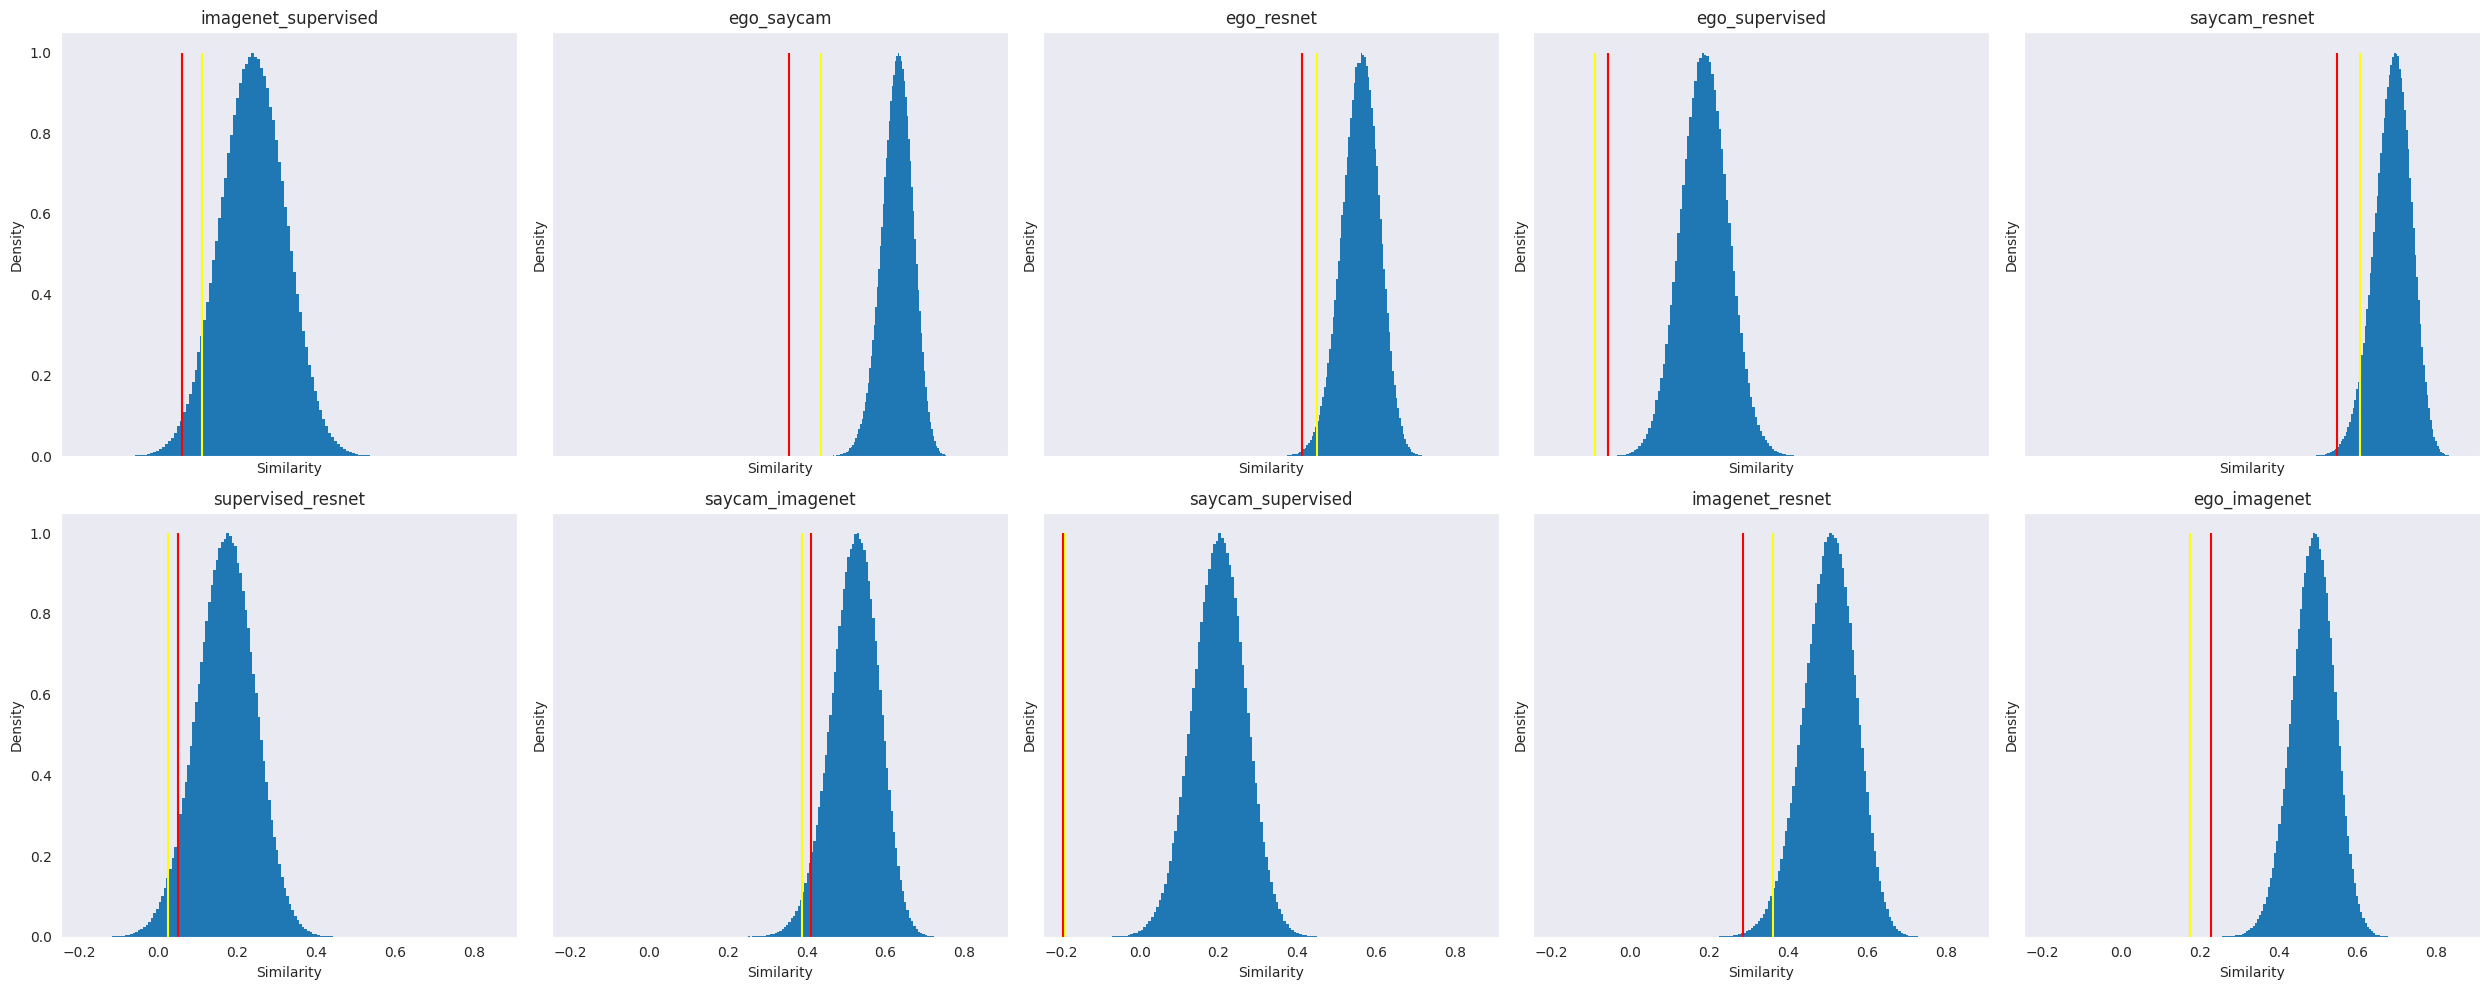

In [63]:
listsamples = glob.glob('results/*Truenormalize.npy')
nb_cols = 5
fig, subs = plt.subplots(nrows = 2, ncols = nb_cols, figsize = (25,10), sharex = True, sharey = True)
for f, file in enumerate(listsamples):
    sample = np.load(file)
    hist, bin_edges = np.histogram(sample, 100)
    subs[int(f/nb_cols), f%nb_cols].bar(bin_edges[:-1],hist/max(hist), width = bin_edges[1] - bin_edges[0], linewidth = 0, align = 'edge')
    #subs[f//5, f%5].legend()
    subs[int(f/nb_cols), f%nb_cols].set_xlabel('Similarity')
    subs[int(f/nb_cols), f%nb_cols].set_ylabel('Density')
    subs[int(f/nb_cols), f%nb_cols].set_title(f'{file.split('_')[-3]}_{file.split('_')[-2]}')
    for name in similarities.keys():
        for p, pair in enumerate(RESULTS[name]['similarity_dict'].keys()):
            if f'{file.split('_')[-3]}_{file.split('_')[-2]}' == pair:
                if ('Truenormalize_silhouette_score_normalizedDiff_pearson' in name) :
                    subs[int(f/nb_cols), f%nb_cols].vlines(similarities[name][p],0,1, 'r')
                elif ('Truenormalize_silhouette_score_normalizedDiff_contrast_pearson' in name) :
                    subs[int(f/nb_cols), f%nb_cols].vlines(similarities[name][p],0,1, 'yellow')
plt.tight_layout()
plt.show()
fig.savefig('figures/compactness/selectionVSdistribution.png')
plt.close()



In [5]:
#### Compute RDMs performing squared euclidean distance as a metric (to be equivalent to CKA methods, cf. Williams, 2024)
RDMs = {}
metric = 'L2squared'
for i, model in enumerate(models):
    print(model)
    RDMs[model] = rsa.compute_RDMs(activations[model], metric = metric, display = False, title = f'{model}_{metric}')
    #RDMs[model] = cka.centering(RDMs[model]) # same as centering with matmul

ego
saycam
imagenet
supervised
random
resnet


In [10]:
def sample_rdm_pairs(RDM1, RDM2, n_samples=100000, subset_size=40,
                                    batch_size=10000, seed=None):
    """
    Memory-efficient version that processes in batches and optionally saves to disk.

    Parameters:
    -----------
    batch_size : int
        Number of samples to process at once (default: 1000)
    output_file : str, optional
        If provided, saves results to this file using pickle
    """

    if seed is not None:
        np.random.seed(seed)

    n_images = RDM1.shape[0]
    n_batches = (n_samples + batch_size - 1) // batch_size

    all_sims_samples = []
    all_indices = []
    print(f"Processing {n_samples} samples in {n_batches} batches of {batch_size}...")

    for batch_idx in tqdm_notebook(range(n_batches)):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, n_samples)
        current_batch_size = end_idx - start_idx

        # Allocate batch arrays
        batch_sim = np.zeros((current_batch_size))
        batch_indices = np.zeros((current_batch_size, subset_size), dtype=int)

        for i in range(current_batch_size):
            # Randomly select images
            indices = np.random.choice(n_images, size=subset_size, replace=False)
            indices = np.sort(indices)

            # Extract submatrices
            batch_sim[i] = rsa.Compute_sim_RDMs(RDM1[np.ix_(indices, indices)], RDM2[np.ix_(indices, indices)], center = False, metric = 'pearson' )
            batch_indices[i] = indices

        all_sims_samples.append(batch_sim)
        all_indices.append(batch_indices)

    # Concatenate all batches
    sim_samples = np.concatenate(all_sims_samples, axis=0)
    indices_used = np.concatenate(all_indices, axis=0)


    return sim_samples, indices_used




In [11]:
models  = ['ego', 'saycam', 'imagenet', 'supervised', 'resnet']

for i, model1 in enumerate(models[:-1]):
    for j, model2 in enumerate(models[i+1:]):
        sim_samples, indices_used = sample_rdm_pairs(RDMs[model1], RDMs[model2], n_samples=100000, subset_size=48, batch_size=1000, seed=None)
        np.save(f'results/sim_samples_{model1}_{model2}_ecoLennyTest.npy', sim_samples)

Processing 100000 samples in 100 batches of 1000...


  0%|          | 0/100 [00:00<?, ?it/s]

Processing 100000 samples in 100 batches of 1000...


  0%|          | 0/100 [00:00<?, ?it/s]

Processing 100000 samples in 100 batches of 1000...


  0%|          | 0/100 [00:00<?, ?it/s]

Processing 100000 samples in 100 batches of 1000...


  0%|          | 0/100 [00:00<?, ?it/s]

Processing 100000 samples in 100 batches of 1000...


  0%|          | 0/100 [00:00<?, ?it/s]

Processing 100000 samples in 100 batches of 1000...


  0%|          | 0/100 [00:00<?, ?it/s]

Processing 100000 samples in 100 batches of 1000...


  0%|          | 0/100 [00:00<?, ?it/s]

Processing 100000 samples in 100 batches of 1000...


  0%|          | 0/100 [00:00<?, ?it/s]

Processing 100000 samples in 100 batches of 1000...


  0%|          | 0/100 [00:00<?, ?it/s]

Processing 100000 samples in 100 batches of 1000...


  0%|          | 0/100 [00:00<?, ?it/s]

In [21]:
listpickles_ecoLennyTest = glob.glob('/home/alban/Documents/results_image_selection/ecoLennyTest_*.pkl')

RESULTS = {}
for p, pkl in enumerate(listpickles_ecoLennyTest):
    name = pkl.split('/')[-1][:-4]
    f = open(pkl,"rb")
    RESULTS[name] = pickle.load(f)
    f.close()

list_names = [k for k in RESULTS.keys()]
similarities = {}

for n, name in enumerate(list_names):
    similarities[name] = [RESULTS[name]['similarity_dict'][pair]['similarity'] for pair in RESULTS[name]['similarity_dict'].keys()]

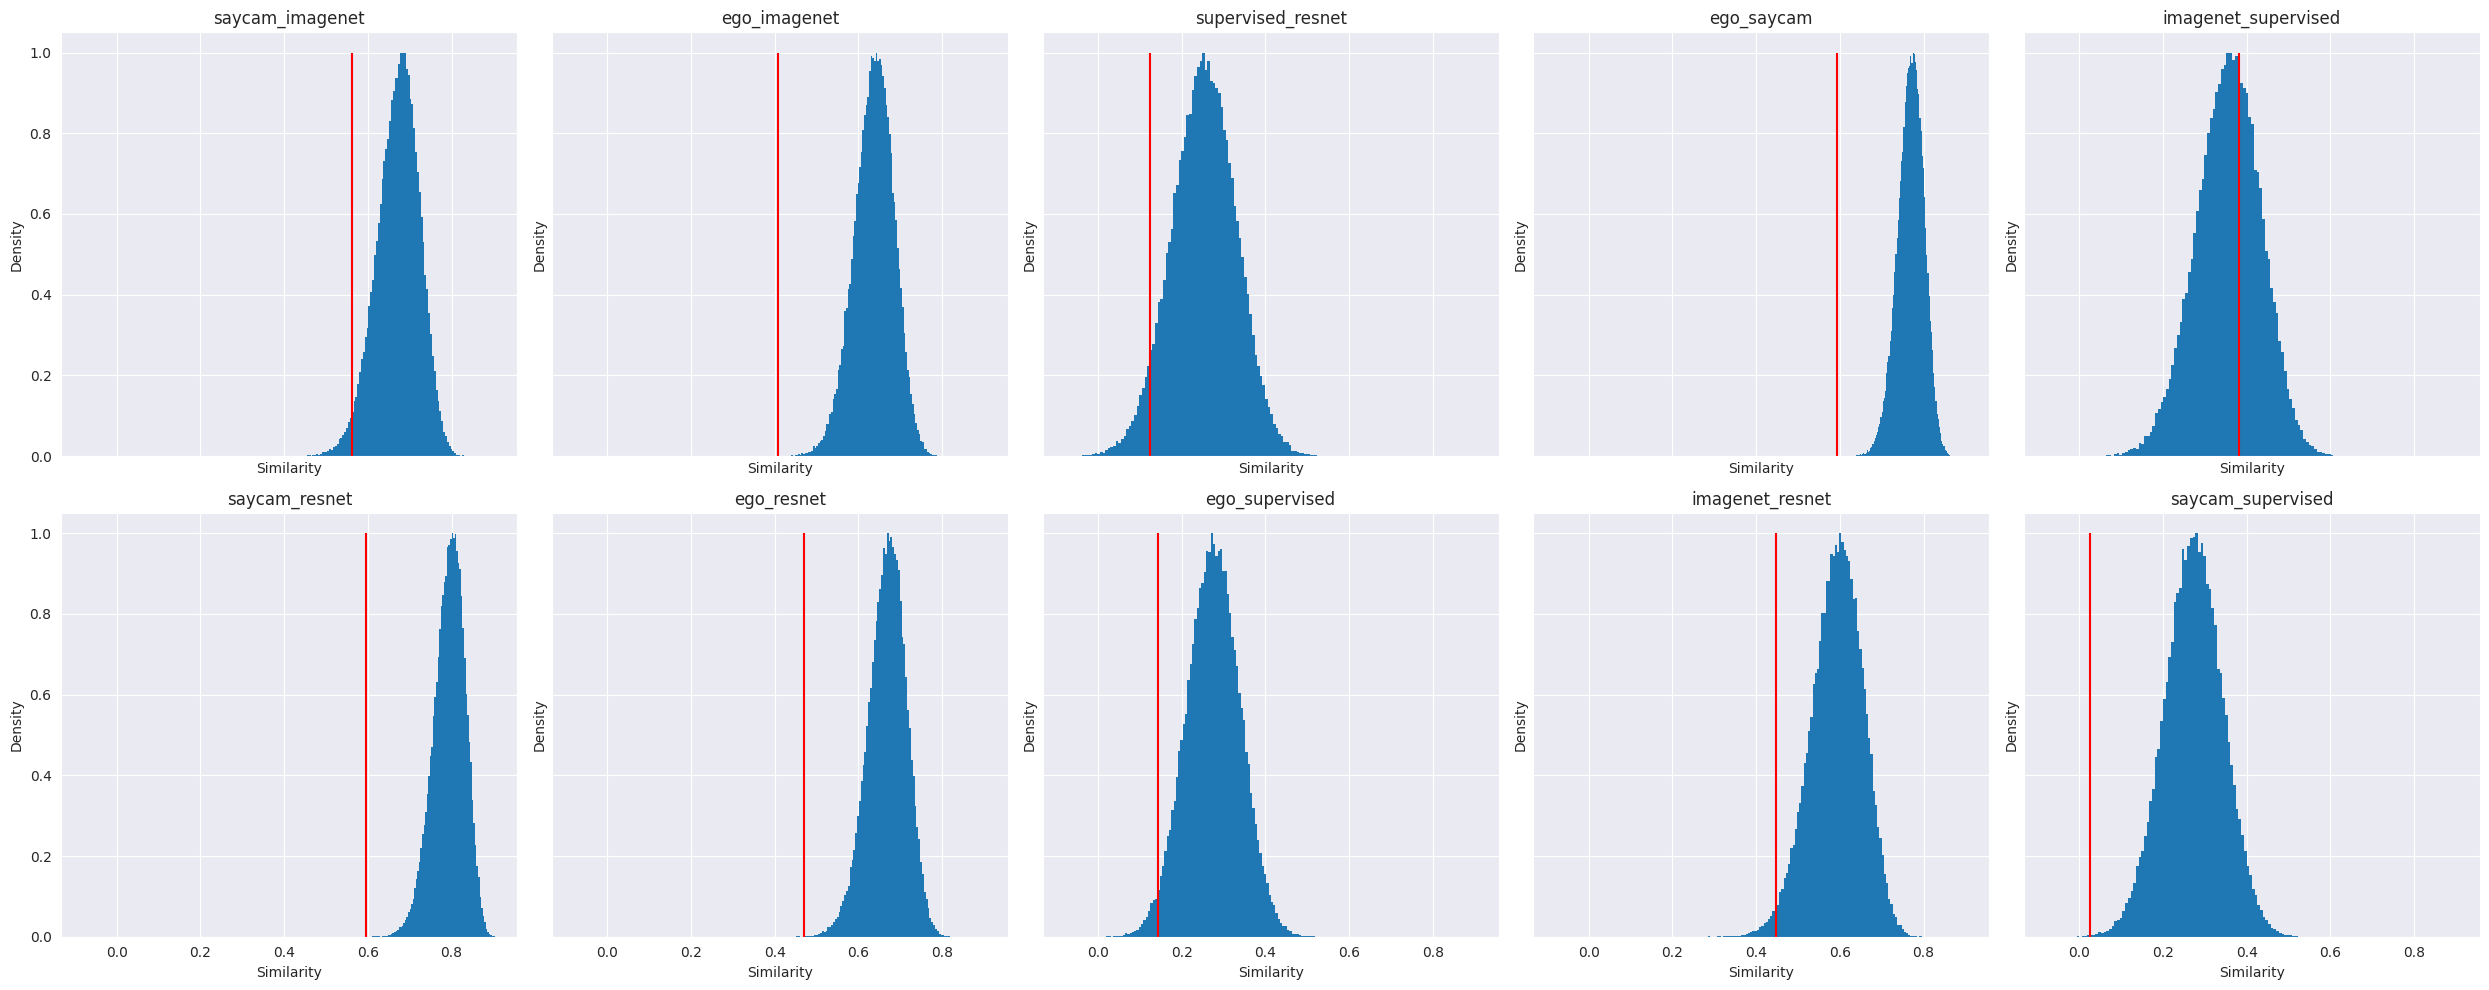

In [22]:
listsamples = glob.glob('results/*ecoLennyTest.npy')
nb_cols = 5
fig, subs = plt.subplots(nrows = 2, ncols = nb_cols, figsize = (25,10), sharex = True, sharey = True)
for f, file in enumerate(listsamples):
    sample = np.load(file)
    hist, bin_edges = np.histogram(sample, 100)
    subs[int(f/nb_cols), f%nb_cols].bar(bin_edges[:-1],hist/max(hist), width = bin_edges[1] - bin_edges[0], linewidth = 0, align = 'edge')
    #subs[f//5, f%5].legend()
    subs[int(f/nb_cols), f%nb_cols].set_xlabel('Similarity')
    subs[int(f/nb_cols), f%nb_cols].set_ylabel('Density')
    subs[int(f/nb_cols), f%nb_cols].set_title(f'{file.split('_')[-3]}_{file.split('_')[-2]}')
    for name in similarities.keys():
        for p, pair in enumerate(RESULTS[name]['similarity_dict'].keys()):
            if f'{file.split('_')[-3]}_{file.split('_')[-2]}' == pair:
                if ('Truenormalize_silhouette_score_normalizedDiff_pearson' in name) :
                    subs[int(f/nb_cols), f%nb_cols].vlines(similarities[name][p],0,1, 'r')

plt.tight_layout()
plt.show()
fig.savefig('figures/compactness/selectionVSdistribution_ecoLennyTest.png')
plt.close()


In [14]:
listsamples

[]